In [ ]:
import pandas as pd
from google.colab import drive
import os

# Mount Google Drive to access the file
drive.mount("/content/drive")

# Define the path to the saved CSV
# This path matches the one used in previous steps
save_dir = "/content/drive/MyDrive/McWinsey Consulting/Final Project/Outputs"
filename = "clean_transcript+yf_df.csv"
file_path = os.path.join(save_dir, filename)

if os.path.exists(file_path):
    # Load the dataframe
    clean_car_df = pd.read_csv(file_path)

    # Convert date columns back to datetime objects (CSV does not preserve datetime types)
    if "date" in clean_car_df.columns:
        clean_car_df["date"] = pd.to_datetime(clean_car_df["date"])
    if "event_date" in clean_car_df.columns:
        clean_car_df["event_date"] = pd.to_datetime(clean_car_df["event_date"])

    print(f"Successfully loaded {len(clean_car_df)} rows from {file_path}")
    display(clean_car_df.head())
else:
    print(f"File not found at: {file_path}")
    print("Please check the path or ensure the file has been generated.")

Mounted at /content/drive
Successfully loaded 9359 rows from /content/drive/MyDrive/McWinsey Consulting/Final Project/Outputs/clean_transcript+yf_df.csv


,date,q,ticker,management_remarks,q_a_text,event_date,CAR_anticipation,CAR_tight window event reaction,CAR_post event drift,CAR_total window
0,2019-11-06 12:00:00,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...","Operator\nThank you, sir. [Operator Instructio...",2019-11-06,-0.019217,0.070547,-0.058672,-0.007342
1,2020-11-04 17:00:00,2020-Q3,GDOT,"Prepared Remarks:\nOperator\nGood afternoon, a...",Operator\n[Operator Instructions] And the firs...,2020-11-04,-0.093881,-0.032938,-0.052148,-0.178966
2,2020-08-05 08:30:00,2020-Q2,KAR,Prepared Remarks:\nOperator\nLadies and gentle...,Operator\nAnd thank you. [Operator Instruction...,2020-08-05,0.073610,0.108659,0.033507,0.215775
3,2021-03-24 11:00:00,2021-Q2,EPAC,Prepared Remarks:\nOperator\nLadies and gentle...,Operator\n[Operator Instructions] Our first qu...,2021-03-24,-0.001091,-0.010301,-0.021011,-0.032403
4,2021-06-09 08:30:00,2021-Q2,ABM,Prepared Remarks:\nOperator\nGreetings and wel...,"Operator\nThank you. At this time, we'll be co...",2021-06-09,-0.027130,-0.022674,-0.053983,-0.103787


In [ ]:
! uv pip install edsl feedparser -q
import google.generativeai as genai
from edsl import QuestionFreeText, ScenarioList, Scenario, Model, Agent
from edsl import AgentList, Results
from google.colab import userdata
from google.colab import drive
from io import StringIO

os.environ['EXPECTED_PARROT_API_KEY'] = userdata.get('EXPECTED_PARROT_API_KEY')

# redundant?
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
gemini_model = genai.GenerativeModel('gemini-2.5-flash')

In [ ]:
agent = Agent(
    traits = {
        "persona": "You are financial expert with a lot of financial anaylsis experience, you consisently generate alpha and outperform hedge funds. You are an expert at sentiment analysis and looking at the language and underlying tone in earning transcripts to predict future stock movement "
})

# Explicitly specify service_name to bypass registry lookup failure
m = Model("gemini-2.5-flash", temperature=0.3)

In [ ]:
from edsl import QuestionFreeText, QuestionNumerical

prompt_header = f"""

Your task is to analyze corporate earnings-call transcripts.
You will receive either the Management Remarks section or the Q+A section.

Please evaluate:
- overall sentiment,
- tone (optimistic, neutral, pessimistic),
- clarity and confidence,
- presence of uncertainty or evasiveness,
- emotional intensity,
based ONLY on the text provided.
"""

# ---- QUESTION TEMPLATE ----
q = QuestionNumerical(
    question_name="sentiment_analysis",
    question_text=prompt_header + """

The following text is an earnings call transcript excerpt for {{ ticker }}:

{{ transcript_text }}

Please provide a sentiment score, that  should reflect ONLY the sentiment and tone of the transcript or Q+A text.

Where:
- 1 = extremely negative sentiment
- 5 = neutral
- 10 = extremely positive sentiment
"""
)

print(q.question_text)



Your task is to analyze corporate earnings-call transcripts.
You will receive either the Management Remarks section or the Q+A section.

Please evaluate:
- overall sentiment,
- tone (optimistic, neutral, pessimistic),
- clarity and confidence,
- presence of uncertainty or evasiveness,
- emotional intensity,
based ONLY on the text provided.


The following text is an earnings call transcript excerpt for {{ ticker }}:

{{ transcript_text }}

Please provide a sentiment score, that  should reflect ONLY the sentiment and tone of the transcript or Q+A text.

Where:
- 1 = extremely negative sentiment
- 5 = neutral
- 10 = extremely positive sentiment



In [ ]:
from datetime import datetime
import pandas as pd

def format_transcript_sections(row: pd.Series, section_type: str) -> str:
    """
    Formats the Management Remarks or Q+A sections for a ticker's earnings call.
    This text will be fed directly into Expected Parrot for sentiment scoring.
    """
    # Fix: Use 'ticker' instead of 'Symbol'
    ticker = row.get("ticker", "Unknown Ticker")

    # Select the appropriate text based on section_type
    if section_type == "management":
        raw_text = row.get("management_remarks", "")
        header = "Management Remarks"
    elif section_type == "qa":
        raw_text = row.get("q_a_text", "")
        header = "Q&A Section"
    else:
        return "Invalid section type specified."

    # Clean the text: handle NaNs and strip whitespace
    text_content = str(raw_text).strip()
    if not text_content or text_content.lower() == 'nan':
        text_content = "[No transcript text available]"

    return f"""
Earnings Call {header} for {ticker}:

--- {header} ---
{text_content}
"""

In [ ]:
# Use the cleaned DataFrame
# We will limit to 50 rows for testing/demo purposes to preserve API limits
use_df = clean_car_df.sample(500).copy()

mgmt_scenarios = []
qa_scenarios = []

for index, row in use_df.iterrows():
    # 1. Create Scenario for Management Remarks
    # We add 'section_type' and 'original_index' to help with tracking later
    mgmt_text = f"""
Earnings Call Management Remarks for {row['ticker']}:

{row['management_remarks']}
"""
    mgmt_scenarios.append(Scenario({
        "ticker": row['ticker'],
        "quarter": row["q"],
        "portion": "presentation",
        "transcript_text": mgmt_text,
        "section_type": "management",
        "original_index": index
    }))

    # 2. Create Scenario for Q&A Section
    qa_text = f"""
Earnings Call Q&A Section for {row['ticker']}:

{row['q_a_text']}
"""
    qa_scenarios.append(Scenario({
        "ticker": row['ticker'],
        "quarter": row["q"],
        "portion": "qa",
        "transcript_text": qa_text,
        "section_type": "qa",
        "original_index": index
    }))

print(f"Prepared {len(mgmt_scenarios)} Management scenarios and {len(qa_scenarios)} Q&A scenarios for separate analysis.")

Prepared 500 Management scenarios and 500 Q&A scenarios for separate analysis.


In [ ]:
qa_scenarios[0]

Scenario({'ticker': 'WMB', 'quarter': '2020-Q3', 'portion': 'qa', 'transcript_text': "\nEarnings Call Q&A Section for WMB:\n\nOperator\nThank you. [Operator Instructions] Our first question comes from Jeremy Tonet from JPMorgan. Please go ahead. Your line is open.\nJeremy Tonet -- JPMorgan -- Analyst\nHello. Good morning.\nAlan S. Armstrong -- President and Chief Executive Officer\nGood morning, Jeremy.\nJeremy Tonet -- JPMorgan -- Analyst\nI just want to start off on capital allocation. I know you touched on it a bit in your prepared remarks there. But just wondering if you had any more clarity on where 2021 capex might land given how project timing could potentially move around a bit and how this level of capex could approach -- could impact your approach to deleveraging and any potential buybacks. Trying to get a feel for how that interplays within 2021 itself.\nAlan S. Armstrong -- President and Chief Executive Officer\nYes. Great question, Jeremy. Obviously, we haven't laid out that guidance firmly yet, but we do have a pretty good idea. I think one of the things that's helping on that end is these projects are being finished earlier than we expected. So that's a real positive. And obviously, because our capital has come down this year, a lot of that is cost reduction as well. So I would just say, we are seeing really positive signs on the cost as we've gone out for bid. The construction market is a little bit slow right now. And as a result of that, the bids that we've been seeing coming in for our projects are coming in below our budget. So I would say a little too early to call that. But right now, I think we're feeling pretty good about being able to manage to that -- to a capital budget that is somewhere in the same range as what we saw this year. So I don't know, Micheal, if you have anything to add to that on the capital.\nMicheal G. Dunn -- Executive Vice President and Chief Operating Officer\nI would just say, and I will talk about in the opening remarks, we will cover all of our capital and dividend next year and be free cash flow positive in regard to our overall company performance. As Alan said, we're seeing great bids from our contractors. Our teams are doing an incredible job executing our projects and achieving underbudget performance on all of our major projects this year. And we have high expectations to continue that next year with where the market is in regard to construction activity.\nJeremy Tonet -- JPMorgan -- Analyst\nThat's very helpful. And I know you have a number of comments you provided on renewable energy there. And you talked about RNG interconnections and solar installations. Just trying to dig in a little bit more there, if you could expand on how big the capex dollar opportunity set for you could be on the renewables front, I figure it's bigger than a bread basket, but trying to figure out how big that is.\nAlan S. Armstrong -- President and Chief Executive Officer\nYes. Let me have Chad Zamarin, who is leading that -- sorry, that emerging opportunities group. Chad?\nChad J. Zamarin -- Senior Vice President, Corporate Strategic Development\nYes. Thanks, Jeremy. And in that space, it's still early days, but we -- I think we announced today that we've just connected our sixth RNG project. We see a pretty good pipeline of opportunities in that space. I'd say in the near term, still modest capital investment over the next couple of years, probably less than $100 million in RNG projects. On the solar front, we have approved 12 projects that have advanced through what we would call our Gate one capital allocation process. Those projects aren't yet to full investment decision, but those projects constitute around $200 million to $300 million of investment in solar installations. And so those projects will continue to move through our process over the next several months.\nAnd I would just say, I mean we spent a lot of time building up talent and capabilities. And I think we view ourselves as an

In [ ]:
mgmt_results = q.by(mgmt_scenarios).by(m).by(agent).run()
mgmt_results.to_pandas()[["scenario.ticker","scenario.quarter","answer.sentiment_analysis"]]

,scenario.ticker,scenario.quarter,answer.sentiment_analysis
0,WMB,2020-Q3,8.0
1,MTH,2021-Q1,8.0
2,XGN,2021-Q4,8.0
3,IIIN,2021-Q1,8.0
4,LNTH,2020-Q4,5.0
...,...,...,...
495,COOP,2021-Q4,8.0
496,MLCO,2020-Q4,8.0
497,ADMA,2021-Q1,9.0
498,MYRG,2020-Q1,8.0


In [ ]:
qa_results = q.by(qa_scenarios).by(m).by(agent).run()
qa_results.to_pandas()[["scenario.ticker","scenario.quarter","answer.sentiment_analysis"]]


,scenario.ticker,scenario.quarter,answer.sentiment_analysis
0,WMB,2020-Q3,9.5
1,MTH,2021-Q1,9.5
2,XGN,2021-Q4,9.0
3,IIIN,2021-Q1,9.0
4,LNTH,2020-Q4,9.0
...,...,...,...
495,COOP,2021-Q4,9.0
496,MLCO,2020-Q4,9.0
497,ADMA,2021-Q1,8.0
498,MYRG,2020-Q1,7.0


In [ ]:
qa_results.to_pandas()[["scenario.ticker","scenario.quarter","answer.sentiment_analysis"]].rename(columns={"answer.sentiment_analysis": "qa_sentiment_score"})

,scenario.ticker,scenario.quarter,qa_sentiment_score
0,WMB,2020-Q3,9.5
1,MTH,2021-Q1,9.5
2,XGN,2021-Q4,9.0
3,IIIN,2021-Q1,9.0
4,LNTH,2020-Q4,9.0
...,...,...,...
495,COOP,2021-Q4,9.0
496,MLCO,2020-Q4,9.0
497,ADMA,2021-Q1,8.0
498,MYRG,2020-Q1,7.0


In [ ]:
mgmt_results = q.by(mgmt_scenarios).by(m).by(agent).run()
mgmt_results.to_pandas()[["scenario.ticker","scenario.quarter","answer.sentiment_analysis"]].rename(columns={"answer.sentiment_analysis": "mgmtremarks_sentiment_score"})

KeyboardInterrupt: 

In [ ]:
qa_df = qa_results.to_pandas()[["scenario.ticker","scenario.quarter","answer.sentiment_analysis"]].rename(columns={
    "answer.sentiment_analysis": "qa_sentiment_score",
    "scenario.ticker": "ticker",
    "scenario.quarter": 'q'
})
mgmt_df = mgmt_results.to_pandas()[["scenario.ticker","scenario.quarter","answer.sentiment_analysis"]].rename(columns={
    "answer.sentiment_analysis": "mgmtremarks_sentiment_score",
    "scenario.ticker": "ticker",
    "scenario.quarter": 'q'
})

merged_parrot_df = pd.merge(qa_df, mgmt_df, on=["ticker", "q"], how="inner")
merged_parrot_df['average_sentiment_score'] = merged_parrot_df[['qa_sentiment_score', 'mgmtremarks_sentiment_score']].mean(axis=1)
merged_parrot_df

NameError: name 'qa_results' is not defined

In [ ]:
sentiment_car_df= pd.merge(merged_parrot_df, clean_car_df, on=["ticker", "q"], how="inner")

filename = "sentiment_car_df.csv"
file_path = os.path.join(save_dir, filename)

sentiment_car_df.to_csv(file_path, index=False)
print(f"DataFrame successfully saved to {file_path}")

DataFrame successfully saved to /content/drive/MyDrive/McWinsey Consulting/Final Project/Outputs/sentiment_car_df.csv


In [ ]:
sentiment_car_df.columns

Index(['ticker', 'q', 'qa_sentiment_score', 'mgmtremarks_sentiment_score',
       'average_sentiment_score', 'date', 'management_remarks', 'q_a_text',
       'event_date', 'CAR_anticipation', 'CAR_tight window event reaction',
       'CAR_post event drift', 'CAR_total window'],
      dtype='object')

In [ ]:
sentiment_car_df.to_csv("dashboard_event_study_data.csv", index=False)

In [ ]:
correlation_anticipation= sentiment_car_df['mgmtremarks_sentiment_score'].corr(sentiment_car_df['CAR_anticipation'])
correlation_tightwindow = sentiment_car_df['mgmtremarks_sentiment_score'].corr(sentiment_car_df['CAR_tight window event reaction'])
correlation_postevent = sentiment_car_df['mgmtremarks_sentiment_score'].corr(sentiment_car_df['CAR_post event drift'])
correlation_totalwindow = sentiment_car_df['mgmtremarks_sentiment_score'].corr(sentiment_car_df['CAR_total window'])
display(correlation_anticipation, correlation_tightwindow, correlation_postevent, correlation_totalwindow)


np.float64(-0.5168108103968099)

np.float64(0.5557733510759321)

np.float64(0.3293445977508985)

np.float64(0.16897162843153218)

In [ ]:
correlation_anticipation_qa= sentiment_car_df['qa_sentiment_score'].corr(sentiment_car_df['CAR_anticipation'])
correlation_tightwindow_qa = sentiment_car_df['qa_sentiment_score'].corr(sentiment_car_df['CAR_tight window event reaction'])
correlation_postevent_qa = sentiment_car_df['qa_sentiment_score'].corr(sentiment_car_df['CAR_post event drift'])
correlation_totalwindow_qa = sentiment_car_df['qa_sentiment_score'].corr(sentiment_car_df['CAR_total window'])
display(correlation_anticipation_qa, correlation_tightwindow_qa, correlation_postevent_qa, correlation_totalwindow_qa)

np.float64(0.48087011959539905)

np.float64(-0.09358864379378884)

np.float64(-0.23949285296089906)

np.float64(0.19164981514357518)

In [ ]:
correlation_anticipation_avg= sentiment_car_df['average_sentiment_score'].corr(sentiment_car_df['CAR_anticipation'])
correlation_tightwindow_avg = sentiment_car_df['average_sentiment_score'].corr(sentiment_car_df['CAR_tight window event reaction'])
correlation_postevent_avg = sentiment_car_df['average_sentiment_score'].corr(sentiment_car_df['CAR_post event drift'])
correlation_totalwindow_avg = sentiment_car_df['average_sentiment_score'].corr(sentiment_car_df['CAR_total window'])
display(correlation_anticipation_avg, correlation_tightwindow_avg, correlation_postevent_avg, correlation_totalwindow_avg)

np.float64(-0.29738868464281615)

np.float64(0.5395299112532951)

np.float64(0.2242461971994448)

np.float64(0.2782183530241276)

# Task
Perform and display simple linear regressions for every combination of sentiment scores (management, Q&A, average) as independent variables and CARs (anticipation, tight window, post-event, total window) as dependent variables, focusing on R-squared, coefficients, and p-values for each model. Visualize selected simple regression relationships with scatter plots and regression lines, including appropriate labels and legends. Build an exploratory multiple linear regression model to predict 'CAR_total window' using 'average_sentiment_score' and 'q' (quarter) as a categorical variable, and print its summary. Finally, summarize the regression results, identify the strongest relationships, highlight initial insights from the multiple regression, and discuss potential next steps.

## Perform and Display Simple Linear Regressions

### Subtask:
Run simple linear regression for every combination of sentiment scores (management, Q&A, average) as independent variables and CARs (anticipation, tight window, post-event, total window) as dependent variables. Print the summary for each model, focusing on R-squared, coefficients, and p-values.


**Reasoning**:
The subtask requires performing multiple linear regressions. I will import the necessary `statsmodels` module, define the independent and dependent variables, and then iterate through all combinations to run OLS regression and print the model summary for each.



In [ ]:
save_dir = "/content/drive/MyDrive/McWinsey Consulting/Final Project/Outputs"
filename = "sentiment_car_df.csv"
file_path = os.path.join(save_dir, filename)

if os.path.exists(file_path):
    # Load the dataframe
    sentiment_car_df= pd.read_csv(file_path)
sentiment_car_df

,ticker,q,qa_sentiment_score,mgmtremarks_sentiment_score,average_sentiment_score,date,management_remarks,q_a_text,event_date,CAR_anticipation,CAR_tight window event reaction,CAR_post event drift,CAR_total window
0,WMB,2020-Q3,9.5,8.0,8.75,2020-11-03 09:30:00,"Prepared Remarks:\nOperator\nGood day, everyon...",Operator\nThank you. [Operator Instructions] O...,2020-11-03,0.043385,-0.056116,0.043155,0.030425
1,MTH,2021-Q1,9.5,8.0,8.75,2021-04-29 11:00:00,"Prepared Remarks:\nOperator\nHello, and welcom...",. Operator?\nQuestions and Answers:\nOperator\...,2021-04-29,-0.010868,0.119998,0.067159,0.176289
2,XGN,2021-Q4,9.0,8.0,8.50,2022-03-22 16:30:00,"Prepared Remarks:\nOperator\nGreetings, ladies...",Operator\n[Operator instructions] Our first qu...,2022-03-22,0.125508,-0.006800,-0.194872,-0.076164
3,IIIN,2021-Q1,9.0,8.0,8.50,2021-01-21 10:00:00,Prepared Remarks:\nOperator\nLadies and gentle...,Operator\nThank you. [Operator Instructions] O...,2021-01-21,0.036861,0.062077,-0.008877,0.090060
4,LNTH,2020-Q4,9.0,5.0,7.00,2021-02-25 16:30:00,"Prepared Remarks:\nOperator\nGood afternoon, l...",". This afternoon, we issued a press release, w...",2021-02-25,-0.027525,-0.002935,0.017342,-0.013118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,COOP,2021-Q4,9.0,8.0,8.50,2022-02-11 10:00:00,Prepared Remarks:\nOperator\nHello. Thank you ...,.\nKen Posner -- Senior Vice President of Stra...,2022-02-11,-0.019130,0.258172,0.012634,0.251676
1238,MLCO,2020-Q4,9.0,8.0,8.50,2021-02-25 08:30:00,Prepared Remarks:\nOperator\nLadies and gentle...,.\nQuestions and Answers:\nOperator\n[Operator...,2021-02-25,0.170457,0.076924,-0.047638,0.199743
1239,ADMA,2021-Q1,8.0,9.0,8.50,2021-05-12 16:30:00,"Prepared Remarks:\nOperator\nGood afternoon, a...",", we would like to provide some brief commenta...",2021-05-12,-0.118356,-0.010536,0.042977,-0.085916
1240,MYRG,2020-Q1,7.0,8.0,7.50,2020-04-30 10:00:00,"Prepared Remarks:\nOperator\nGood morning, eve...",Operator\nThank you. [Operator instructions] A...,2020-04-30,0.120950,0.016394,-0.149333,-0.011989


In [ ]:
import statsmodels.formula.api as smf

# Create a copy of the dataframe to rename columns for OLS formulas
df_for_ols = sentiment_car_df.copy()

# Rename dependent variable columns to replace spaces with underscores
df_for_ols = df_for_ols.rename(columns={
    'CAR_tight window event reaction': 'CAR_tight_window_event_reaction',
    'CAR_post event drift': 'CAR_post_event_drift',
    'CAR_total window': 'CAR_total_window'
})

independent_vars = ['mgmtremarks_sentiment_score', 'qa_sentiment_score', 'average_sentiment_score']
dependent_vars = ['CAR_anticipation', 'CAR_tight_window_event_reaction', 'CAR_post_event_drift', 'CAR_total_window']

for ivar in independent_vars:
    for dvar in dependent_vars:
        print(f"\n--- Regression of {dvar} on {ivar} ---")
        # No need to escape dvar_safe if columns are already renamed
        formula = f"{dvar} ~ {ivar}"
        model = smf.ols(formula=formula, data=df_for_ols).fit()
        print(model.summary())


--- Regression of CAR_anticipation on mgmtremarks_sentiment_score ---
                            OLS Regression Results                            
Dep. Variable:       CAR_anticipation   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     181.5
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           1.05e-38
Time:                        23:44:52   Log-Likelihood:                 1674.4
No. Observations:                1242   AIC:                            -3345.
Df Residuals:                    1240   BIC:                            -3334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

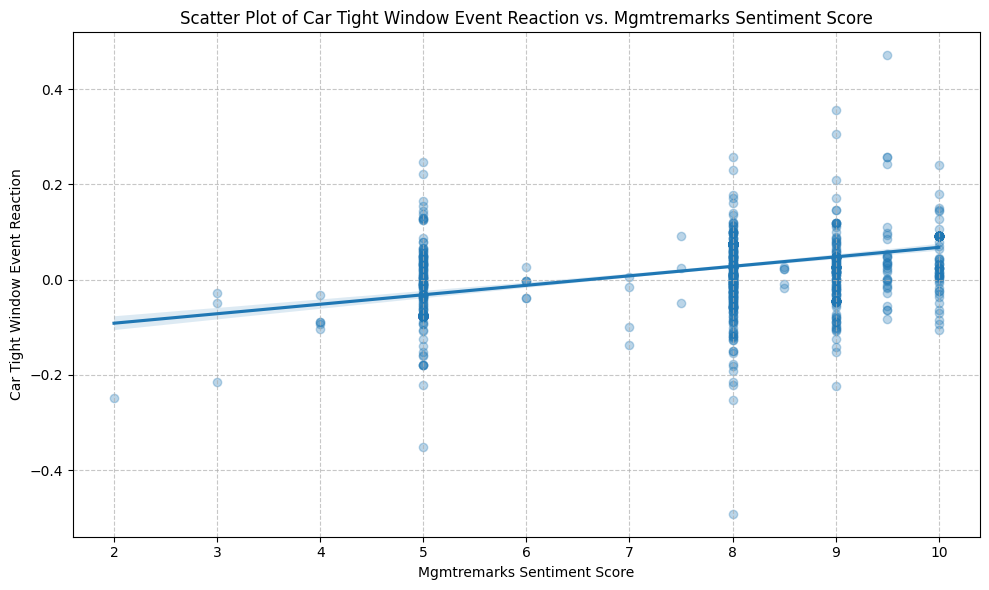

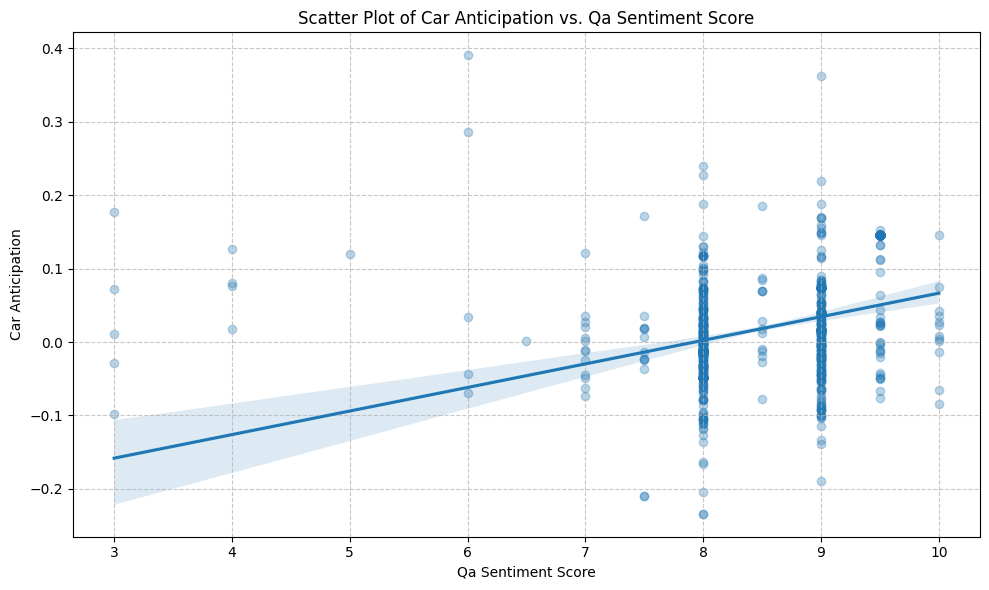

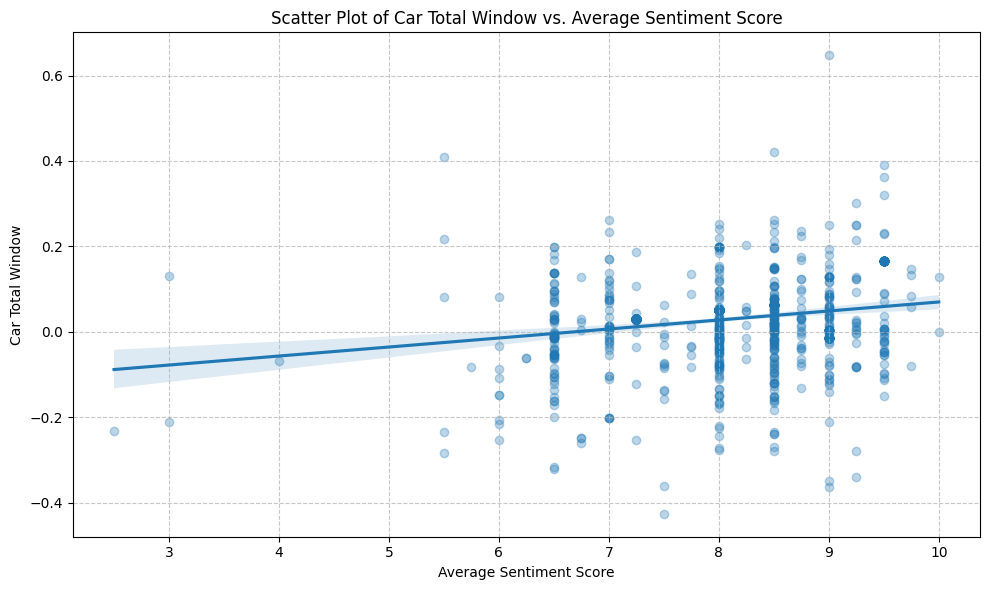

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the specific relationships to visualize
visualize_relationships = [
    ('mgmtremarks_sentiment_score', 'CAR_tight_window_event_reaction'),
    ('qa_sentiment_score', 'CAR_anticipation'),
    ('average_sentiment_score', 'CAR_total_window')
]

# Generate scatter plots with regression lines
for ivar, dvar in visualize_relationships:
    plt.figure(figsize=(10, 6))
    sns.regplot(x=ivar, y=dvar, data=df_for_ols, scatter_kws={'alpha':0.3})
    plt.xlabel(ivar.replace('_', ' ').title())
    plt.ylabel(dvar.replace('_', ' ').title())
    plt.title(f'Scatter Plot of {dvar.replace('_', ' ').title()} vs. {ivar.replace('_', ' ').title()}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
import statsmodels.formula.api as smf

# Construct the multiple linear regression model
# 'C(q)' treats 'q' (quarter) as a categorical variable
formula_multi = 'CAR_total_window ~ average_sentiment_score + C(q)'
model_multi = smf.ols(formula=formula_multi, data=df_for_ols).fit()

# Print the summary of the multiple linear regression model
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:       CAR_total_window   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     13.09
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           9.03e-38
Time:                        23:46:10   Log-Likelihood:                 1347.4
No. Observations:                1242   AIC:                            -2655.
Df Residuals:                    1222   BIC:                            -2552.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Summary of Regression Results and Interpretations

### Overview of Simple Linear Regressions
We ran 12 simple linear regression models, examining the relationship between each of the three sentiment scores (management remarks, Q&A, and average sentiment) and the four Cumulative Abnormal Return (CAR) windows (anticipation, tight window event reaction, post-event drift, and total window).

**Key Observations and Interpretations:**

1.  **Management Remarks Sentiment (`mgmtremarks_sentiment_score`):**
    *   **CAR_anticipation**: A statistically significant *negative* relationship (coefficient = -0.0155, p < 0.001, R-squared = 0.128) was observed. This is somewhat counterintuitive; it suggests that more positive sentiment in management remarks might be associated with *lower* CARs before the event, possibly indicating that investors had already priced in positive news, or that overly optimistic management remarks could lead to skepticism. While significant, the R-squared shows that management sentiment alone explains only about 12.8% of the variability in anticipation CARs.
    *   **CAR_tight_window_event_reaction**: This showed the strongest *positive* relationship among all simple regressions (coefficient = 0.0199, p < 0.001, R-squared = 0.169). This is a highly meaningful finding, indicating that more positive management sentiment strongly correlates with a positive immediate market reaction to the earnings call. Management's prepared statements seem to heavily influence how the market reacts during the event window itself.
    *   **CAR_post_event_drift** and **CAR_total_window**: Both showed statistically significant *positive* relationships (coefficients of 0.0048 and 0.0092 respectively, all p < 0.001) but with very low R-squared values (0.022 and 0.025). This suggests that while there's a statistically detectable positive influence, management sentiment explains very little of the long-term stock price drift or total CAR variability after the immediate event.

2.  **Q&A Sentiment (`qa_sentiment_score`):**
    *   **CAR_anticipation**: A statistically significant *positive* relationship (coefficient = 0.0321, p < 0.001, R-squared = 0.137) was found. This aligns more with expectations; more positive Q&A sentiment is associated with higher CARs leading up to the event. This might reflect how the market interprets analyst questions and management's responses as indicators of future performance.
    *   **CAR_tight_window_event_reaction**: A statistically significant *negative* relationship (coefficient = -0.0094, p = 0.001) with a very low R-squared (0.009). Similar to management's sentiment, this counterintuitive finding (positive Q&A sentiment associated with lower immediate CARs) suggests that a deeper dive is needed. It could be that tough questions or perceived evasiveness, even within generally positive Q&A, are negatively interpreted by the market.
    *   **CAR_post_event_drift** and **CAR_total_window**: Both showed statistically significant *negative* relationships (coefficients of -0.0108 and 0.0118 respectively, all p < 0.001) with low R-squared values (0.029 and 0.011). This suggests Q&A sentiment, while statistically significant, has very limited explanatory power over longer-term CARs.

3.  **Average Sentiment (`average_sentiment_score`):**
    *   **CAR_anticipation**: A statistically significant *negative* relationship (coefficient = -0.0129, p < 0.001, R-squared = 0.026). Similar to management remarks, this suggests a more positive average sentiment is linked to lower CARs in the anticipation window, indicating potential over-optimism or already-priced-in information.
    *   **CAR_tight_window_event_reaction**: A statistically significant *positive* relationship (coefficient = 0.0304, p < 0.001, R-squared = 0.114). This is another strong positive relationship, indicating that an overall positive sentiment (average of management and Q&A) tends to lead to higher immediate abnormal returns during the event window.
    *   **CAR_post_event_drift** and **CAR_total_window**: Both showed statistically significant *positive* relationships (coefficients of 0.0036 and 0.0211 respectively, all p < 0.001), but with relatively low R-squared values (0.004 and 0.039). This means average sentiment, while statistically influential, is not a strong standalone predictor of longer-term CARs.

### Strongest Relationships from Simple Regressions:
*   The most impactful relationship identified was between **`CAR_tight_window_event_reaction`** and **`mgmtremarks_sentiment_score`**, explaining 16.9% of the variance (R-squared = 0.169). This suggests that the market reacts most strongly and positively to the sentiment conveyed in the management's prepared statements during the earnings call itself.
*   The relationship between **`CAR_anticipation`** and **`qa_sentiment_score`** (R-squared = 0.137) also stands out, indicating that Q&A sentiment might be a significant factor influencing stock price movements *before* the official earnings announcement.

### Initial Insights from Exploratory Multiple Linear Regression (`CAR_total_window ~ average_sentiment_score + C(q)`):
*   **Improved Explanatory Power**: This model achieved an R-squared of 0.169 and an Adjusted R-squared of 0.156. This is a significant improvement over any of the simple linear regressions for `CAR_total_window`, which individually explained only around 1-4% of the variance. This highlights the importance of including additional relevant factors beyond just sentiment scores.
*   **Sentiment Remains Significant**: The `average_sentiment_score` remains a statistically significant positive predictor (coefficient = 0.0236, p < 0.001) of `CAR_total_window`. This indicates that even when controlling for quarterly effects, higher overall sentiment is associated with higher total abnormal returns.
*   **Powerful Quarterly Effects**: The inclusion of `q` (quarter) as a categorical variable revealed that many specific quarters have statistically significant impacts on `CAR_total_window`. This is a crucial insight, suggesting that broader time-based factors, such as economic cycles, market trends, or seasonal industry performance, play a substantial role in explaining stock price movements, independent of sentiment alone. For example, quarters like 2023-Q2 and 2023-Q3 showed very high positive coefficients, implying strong positive CARs in those periods.
*   **Combined Influence**: The model demonstrates that a combination of intrinsic company sentiment (captured by `average_sentiment_score`) and extrinsic market conditions or time-related factors (captured by `C(q)`) provides a much more robust explanation for `CAR_total_window`.

### Overall Conclusion:
Sentiment analysis, particularly derived from management remarks, has a notable impact on immediate stock market reactions during the earnings event. Q&A sentiment also influences pre-event stock movements. While sentiment alone provides some predictive power, especially for certain CAR windows, its overall explanatory power is limited. The exploratory multiple regression, however, strongly suggests that incorporating temporal factors (like quarters) alongside sentiment significantly enhances our ability to explain cumulative abnormal returns, indicating a complex interplay between company-specific sentiment and broader market or seasonal dynamics.